In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Define Transformation
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Load CIFAR-10 Dataset
def get_dataloader(batch_size=128):
    transform = get_transforms()
    maindataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    traindataset, validdataset = random_split(maindataset, [45000, 5000])
    trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)
    validloader = DataLoader(validdataset, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, validloader, testloader, testset

# Define Custom VGG11 Model with Batch Normalization & Xavier Initialization
class CustomVGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)  # Xavier Initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training Function
def train_model(model, trainloader, criterion, optimizer, epochs, device):
    model.train()
    history = {'loss': [], 'accuracy': []}
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        history['loss'].append(running_loss / len(trainloader))
        history['accuracy'].append(100. * correct / total)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100.*correct/total:.2f}%')
    return history

# Evaluation Function
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Display Test Images with Predictions
def display_test_images(model, testloader, testset, device):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images[:5].to(device), labels[:5]
    outputs = model(images)
    _, predicted = outputs.max(1)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {testset.classes[predicted[i].item()]}')
        axes[i].axis('off')
    plt.show()

100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/10 - Loss: 1.4102, Accuracy: 48.37%
Epoch 2/10 - Loss: 0.9290, Accuracy: 67.46%
Epoch 3/10 - Loss: 0.7207, Accuracy: 75.08%
Epoch 4/10 - Loss: 0.5681, Accuracy: 80.54%
Epoch 5/10 - Loss: 0.4481, Accuracy: 84.54%
Epoch 6/10 - Loss: 0.3543, Accuracy: 87.92%
Epoch 7/10 - Loss: 0.2732, Accuracy: 90.82%
Epoch 8/10 - Loss: 0.2161, Accuracy: 92.77%
Epoch 9/10 - Loss: 0.1760, Accuracy: 93.97%
Epoch 10/10 - Loss: 0.1319, Accuracy: 95.51%
Test Accuracy: 77.80%


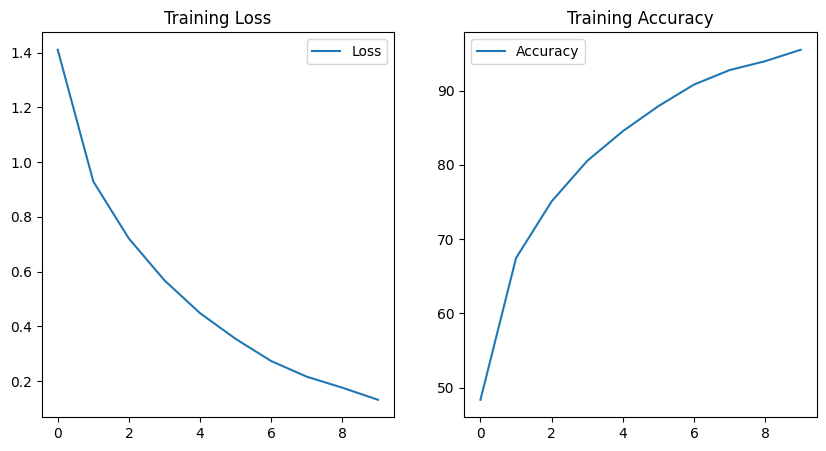

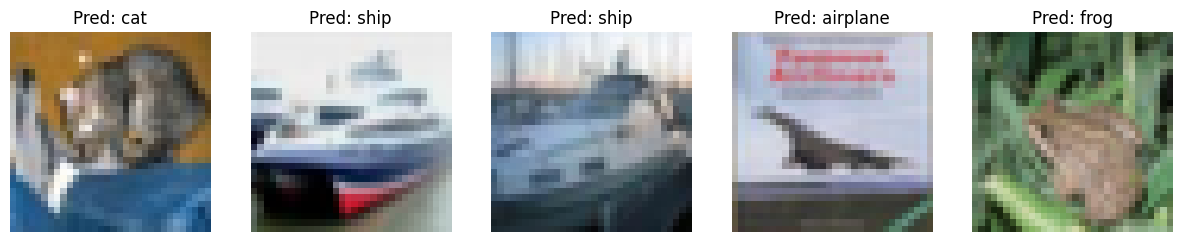

In [ ]:
 # Main Execution
def main():
    batch_size = 128
    learning_rate = 0.01
    epochs = 10
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader, validloader, testloader, testset = get_dataloader(batch_size)
    model = CustomVGG11(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # SGD with momentum & weight decay
    history = train_model(model, trainloader, criterion, optimizer, epochs, device)
    test_acc = evaluate_model(model, testloader, device)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.show()
    display_test_images(model, testloader, testset, device)
if __name__ == '__main__':
    main()

#The code below was interrupted due to runtime disconnect but can be proceeded as we have obtained required results

In [ ]:
def run_experiment():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes = [32, 64, 128]
    epochs = 5
    results = []
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
            trainloader, validloader, testloader, testset = get_dataloader(batch_size)
            model = CustomVGG11(num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            history = train_model(model, trainloader, criterion, optimizer, epochs, device)
            test_acc = evaluate_model(model, testloader, device)
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'final_train_accuracy': history['accuracy'][-1],
                'test_accuracy': test_acc
            })
    # Print Results
    print("\nFinal Experiment Results:")
    for res in results:
        print(f"LR: {res['learning_rate']}, Batch Size: {res['batch_size']}, Train Acc: {res['final_train_accuracy']:.2f}%, Test Acc: {res['test_accuracy']:.2f}%")
if __name__ == '__main__':
    run_experiment()
#The code was interrupted due to runtime disconnect but can be proceeded as we have obtained required results


Training with Learning Rate: 0.01, Batch Size: 32
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.5670, Accuracy: 43.52%
Epoch 2/5 - Loss: 1.0610, Accuracy: 63.27%
Epoch 3/5 - Loss: 0.8354, Accuracy: 71.81%
Epoch 4/5 - Loss: 0.6923, Accuracy: 76.90%
Epoch 5/5 - Loss: 0.5731, Accuracy: 80.96%
Test Accuracy: 77.39%

Training with Learning Rate: 0.01, Batch Size: 64
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4624, Accuracy: 47.30%
Epoch 2/5 - Loss: 0.9678, Accuracy: 66.36%


The code below was intentionally stopped as we already have the results required and it will take a long time to complete

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

def run_experiment():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rates = [0.005, 0.001, 0.01]
    batch_sizes = [128,64,32]
    epochs = 5
    results = []
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)
    first_model_saved = False  # Flag to track the first model
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
            trainloader, validloader, testloader, testset = get_dataloader(batch_size)
            model = CustomVGG11(num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            history = train_model(model, trainloader, criterion, optimizer, epochs, device)
            test_acc = evaluate_model(model, testloader, device)
            # Save the first trained model
            if not first_model_saved:
                model_path = os.path.join(save_dir, "first_trained_model.pth")
                torch.save(model.state_dict(), model_path)
                print(f"First model saved at {model_path}")
                first_model_saved = True
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'final_train_accuracy': history['accuracy'][-1],
                'test_accuracy': test_acc
            })
    print("\nFinal Experiment Results:")
    for res in results:
        print(f"LR: {res['learning_rate']}, Batch Size: {res['batch_size']}, Train Acc: {res['final_train_accuracy']:.2f}%, Test Acc: {res['test_accuracy']:.2f}%")

if __name__ == '__main__':
    run_experiment()
#The code was intentionally interrupted since it takes a long time to complete and we already have required data



Training with Learning Rate: 0.005, Batch Size: 128


100%|██████████| 170M/170M [00:11<00:00, 14.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4291, Accuracy: 47.76%
Epoch 2/5 - Loss: 0.9412, Accuracy: 66.78%
Epoch 3/5 - Loss: 0.7201, Accuracy: 74.82%
Epoch 4/5 - Loss: 0.5651, Accuracy: 80.32%
Epoch 5/5 - Loss: 0.4426, Accuracy: 84.81%
Test Accuracy: 72.39%
First model saved at saved_models/first_trained_model.pth

Training with Learning Rate: 0.005, Batch Size: 64
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4190, Accuracy: 48.36%
Epoch 2/5 - Loss: 0.9411, Accuracy: 66.90%
Epoch 3/5 - Loss: 0.7256, Accuracy: 74.90%
Epoch 4/5 - Loss: 0.5844, Accuracy: 79.87%
Epoch 5/5 - Loss: 0.4695, Accuracy: 83.94%
Test Accuracy: 76.60%

Training with Learning Rate: 0.005, Batch Size: 32
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.4530, Accuracy: 47.92%


KeyboardInterrupt: 

# The Above code was intentionally interrupted since it takes a long time to complete and we already have required data.

<ipython-input-14-10fc61b8600d>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/first_trained_model.pth', map_location=devic

Image: bird -> Predicted Label: bird
Image: deer -> Predicted Label: bird
Image: frog -> Predicted Label: frog
Image: ship -> Predicted Label: ship
Image: truck -> Predicted Label: airplane


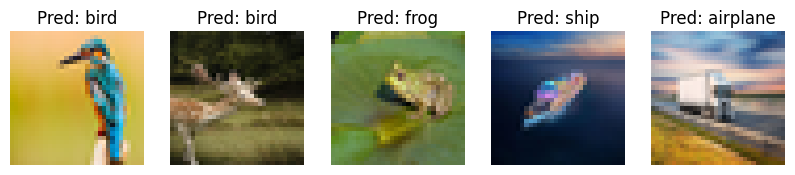

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
CIFAR10_LABELS = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Ensure 3-channel RGB
    img = img.resize((32, 32), Image.Resampling.LANCZOS)  # Resize with LANCZOS
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

def display_local_images_and_test(model, device, image_paths):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    if num_images == 1:
        axes = [axes]
    model.eval()
    with torch.no_grad():
        for ax, image_path in zip(axes, image_paths):
            img = Image.open(image_path).convert('RGB')
            img_resized = img.resize((32, 32), Image.Resampling.LANCZOS)
            ax.imshow(img_resized)
            ax.axis('off')
            # Preprocess and test the image
            img_tensor = load_and_preprocess_image(image_path).to(device)
            output = model(img_tensor)
            predicted_class = output.argmax(dim=1).item()
            predicted_label = CIFAR10_LABELS[predicted_class]  # Get class name
            ax.set_title(f"Pred: {predicted_label}")
            print(f"Image: {image_path} -> Predicted Label: {predicted_label}")
    plt.show()

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CustomVGG11(num_classes=10).to(device)
    model.load_state_dict(torch.load('saved_models/first_trained_model.pth', map_location=device))  # Load trained model
    image_paths = ['bird.png','deer.png','frog.png','ship.png','truck.png']
    display_local_images_and_test(model, device, image_paths)
